# KLD CUSIP Correction

<div class="alert alert-block alert-warning">
<b>Warning:</b> KLD does not provide CUSIP before 1994. Also, some CUSIP digits are wrongly shifted by omitting one or two zeros in front. When backfill also set '0' and '#N/A' to NA first.
</div>

## Obtain data

In [50]:
import wrds
import matplotlib.pyplot as plt

In [2]:
db = wrds.Connection()

Loading library list...
Done


In [3]:
kld = db.get_table(library='kld', table='history', columns=['companyname', 'cusip', 'ticker', 'companyid', 'year', 'domicile'])
kld.shape

(53168, 6)

In [4]:
kld.sort_values(['year', 'ticker'], inplace=True);

For example, look at the CUSIP of Apple. CUSIP before 1995 is missing and some CUSIP-8-digit wrongly recorded as "37833100" instead of "03783310"!

In [5]:
kld[kld['ticker']=='AAPL']

,companyname,cusip,ticker,companyid,year,domicile
1632,"Apple Computer, Inc.",None,AAPL,None,1991.0,None
1633,"Apple Computer, Inc.",None,AAPL,None,1992.0,None
1634,"Apple Computer, Inc.",None,AAPL,None,1993.0,None
1635,"Apple Computer, Inc.",None,AAPL,None,1994.0,None
1636,"Apple Computer, Inc.",03783310,AAPL,None,1995.0,None
1637,"Apple Computer, Inc.",03783310,AAPL,None,1996.0,None
1638,"Apple Computer, Inc.",03783310,AAPL,None,1997.0,None
1640,"Apple Computer, Inc.",03783310,AAPL,None,1998.0,None
1641,"Apple Computer, Inc.",03783310,AAPL,None,1999.0,None
1642,"Apple Computer, Inc.",37833100,AAPL,None,2000.0,None


To correct the wrongly shifted CUSIPs, I first shift the CUSIP digits to the right and add "0"'s in front. Then take the first 8 digits and compare them to the original 8-digit-CUSIP. If there're sets of intersection, this means there are wrongly shifted CUSIPs. I collect this set of wrongly shifted CUSIPs and create a dictionary to map them back to the correct CUSIPs correspondingly.

In [6]:
kld['0cusip7']='0' + kld['cusip'].str[0:7]
kld['00cusip6']= '00' + kld['cusip'].str[0:6]
kld['000cusip5']= '000' + kld['cusip'].str[0:5]

The list of CUSIPs that requires adding '0' in front:

In [7]:
lst111=kld['cusip'].unique()
lst222=kld['0cusip7'].unique()
lst8 = sorted(list(set(lst111) & set(lst222)))
len(lst8)

274

The list of CUSIPs that requires adding '00' in front:

In [8]:
lst1111=kld['cusip'].unique()
lst2222=kld['00cusip6'].unique()
lst88 = sorted(list(set(lst1111) & set(lst2222)))
len(lst88)

59

The list of CUSIPs that requires adding '000' in front:

In [9]:
lst11111=kld['cusip'].unique()
lst22222=kld['000cusip5'].unique()
lst888 = sorted(list(set(lst11111) & set(lst22222)))
len(lst888)

5

Create dictionary mapping wrong CUSIPs to their corresponding correct CUSIPs: 

In [20]:
rcdict0 = {}
for c in lst8:
    if len(set(kld[kld['0cusip7']==c]['cusip']))==1:
        #print(len(set(kld[kld['0cusip7']==c]['cusip']))==1) # check if wrongly shifted cusip-8-digit is unique
        _c = list(kld[kld['0cusip7']==c]['cusip'])[0]
    rcdict0[_c] = c

In [12]:
# two zero added in front
lst88.remove('00030710')
rcdict00 = {}
for c in lst88:
    if len(set(kld[kld['00cusip6']==c]['cusip']))==1:
        #print(len(set(kld[kld['00cusip6']==c]['cusip']))==1) # check if wrongly shifted cusip-8-digit is unique
        _c = list(kld[kld['00cusip6']==c]['cusip'])[0]
    rcdict00[_c] = c

In [13]:
# three zero added in front
lst888.remove('00030710')
rcdict000 = {}
for c in lst888:
    if len(set(kld[kld['000cusip5']==c]['cusip']))==1:
        #print(len(set(kld[kld['00cusip6']==c]['cusip']))==1) # check if wrongly shifted cusip-8-digit is unique
        _c = list(kld[kld['000cusip5']==c]['cusip'])[0]
    rcdict000[_c] = c

In [14]:
# Some hand maps
cusip6Dict = {"18772103":"01877210",
              "01877230":"01877210",
              "886309":"00088630"}

Merging all dictionaries above:

In [15]:
cusipDict = {**rcdict0, **rcdict00, **rcdict000, **cusip6Dict}

Check the total length of key-value pairs:

In [16]:
len(cusipDict) == len(rcdict0) + len(rcdict00) + len(rcdict000) + len(cusip6Dict)

True

In [41]:
counter2 = 0
for d in cusipDict.keys():
    print('Wrong CUSIP: ' + str(d) + ' | Corresponding correct CUSIP: ' + str(cusipDict[d]) + '\n')
    print(kld[kld.cusip==d][['companyname', 'cusip', 'ticker', 'companyid', 'year']])
    count = len(kld[kld.cusip==d])
    counter2 += count
    print('\nNumber of wrong CUSIP observations: ' + str(count) +
          '\nCumulated wrong CUSIP observations: ' + str(counter2) 
          + '\n============================================================================\n\n')
print('\nTotal number of distinct wrong CUSIP: ' + str(len(cusipDict)))

Wrong CUSIP: 10317105 | Corresponding correct CUSIP: 01031710

                          companyname     cusip ticker     companyid    year
3570  Alabama National BanCorporation  10317105   ALAB          None  2005.0
3571  Alabama National BanCorporation  10317105   ALAB          None  2006.0
3572  Alabama National BanCorporation  10317105   ALAB          5239  2007.0

Number of wrong CUSIP observations: 3
Cumulated wrong CUSIP observations: 3


Wrong CUSIP: 11311107 | Corresponding correct CUSIP: 01131110

           companyname     cusip ticker     companyid    year
3672  Alamo Group Inc.  11311107    ALG          None  2005.0
3673  Alamo Group Inc.  11311107    ALG          8754  2008.0
3674  Alamo Group Inc.  11311107    ALG          8754  2009.0
3675  Alamo Group Inc.  11311107    ALG          8754  2010.0
3676  Alamo Group Inc.  11311107    ALG          8754  2011.0
3677  ALAMO GROUP INC.  11311107    ALG          None  2012.0
3679  ALAMO GROUP INC.  11311107    ALG          None


Number of wrong CUSIP observations: 2
Cumulated wrong CUSIP observations: 74


Wrong CUSIP: 14752109 | Corresponding correct CUSIP: 01475210

            companyname     cusip ticker     companyid    year
3926  Alexander's, Inc.  14752109    ALX          None  2005.0
3927  Alexander's, Inc.  14752109    ALX          None  2006.0
3928  Alexander's, Inc.  14752109    ALX          5246  2007.0
3929  Alexander's, Inc.  14752109    ALX          5246  2008.0
3930  Alexander's, Inc.  14752109    ALX          5246  2009.0
3931  Alexander's, Inc.  14752109    ALX          5246  2010.0
3932  Alexander's, Inc.  14752109    ALX          5246  2011.0
3933  Alexander's, Inc.  14752109    ALX          None  2012.0
3935  ALEXANDER'S, INC.  14752109    ALX          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 83


Wrong CUSIP: 15271109 | Corresponding correct CUSIP: 01527110

                          companyname     cusip ticker     companyid    year
5077  A

                            companyname     cusip ticker     companyid    year
2526  Alliance Data Systems Corporation  18581108    ADS          None  2005.0
2527  Alliance Data Systems Corporation  18581108    ADS          None  2006.0
2528  Alliance Data Systems Corporation  18581108    ADS          9532  2007.0
2529  Alliance Data Systems Corporation  18581108    ADS          9532  2008.0
2530  Alliance Data Systems Corporation  18581108    ADS          9532  2009.0
2531  Alliance Data Systems Corporation  18581108    ADS          9532  2010.0
2532  Alliance Data Systems Corporation  18581108    ADS          9532  2011.0
2533  Alliance Data Systems Corporation  18581108    ADS          None  2012.0
2536  ALLIANCE DATA SYSTEMS CORPORATION  18581108    ADS          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 163


Wrong CUSIP: 18606202 | Corresponding correct CUSIP: 01860620

                             companyname     cusip ticker     comp

           companyname     cusip ticker companyid    year
6425  ALZA Corporation  22615108    AZA      None  2000.0

Number of wrong CUSIP observations: 1
Cumulated wrong CUSIP observations: 234


Wrong CUSIP: 23135106 | Corresponding correct CUSIP: 02313510

           companyname     cusip ticker     companyid    year
4435  Amazon.com, Inc.  23135106   AMZN          None  2005.0
4436  Amazon.com, Inc.  23135106   AMZN          None  2006.0
4437  Amazon.com, Inc.  23135106   AMZN          6295  2007.0
4438  Amazon.com, Inc.  23135106   AMZN          6295  2008.0
4439  Amazon.com, Inc.  23135106   AMZN          6295  2009.0
4440  Amazon.com, Inc.  23135106   AMZN          6295  2010.0
4441  Amazon.com, Inc.  23135106   AMZN          6295  2011.0
4431  Amazon.com, Inc.  23135106   AMZN          None  2012.0
4443  AMAZON.COM, INC.  23135106   AMZN          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 243


Wrong CUSIP: 23139108 | Corresponding c

6319          None  2014.0  

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 307


Wrong CUSIP: 24835100 | Corresponding correct CUSIP: 02483510

                            companyname     cusip ticker     companyid    year
2014  American Campus Communities, Inc.  24835100    ACC          None  2005.0
2015  American Campus Communities, Inc.  24835100    ACC          None  2006.0
2016  American Campus Communities, Inc.  24835100    ACC         12207  2007.0
2017  American Campus Communities, Inc.  24835100    ACC         12207  2008.0
2018  American Campus Communities, Inc.  24835100    ACC         12207  2009.0
2019  American Campus Communities, Inc.  24835100    ACC         12207  2010.0
2020  American Campus Communities, Inc.  24835100    ACC         12207  2011.0
2021  American Campus Communities, Inc.  24835100    ACC          None  2012.0
2024  AMERICAN CAMPUS COMMUNITIES, INC.  24835100    ACC          None  2014.0

Number of wrong CUSIP observations: 


Number of wrong CUSIP observations: 8
Cumulated wrong CUSIP observations: 391


Wrong CUSIP: 28884104 | Corresponding correct CUSIP: 02888410

                            companyname     cusip ticker     companyid    year
1986  American Physicians Capital, Inc.  28884104   ACAP          None  2005.0
1987  American Physicians Capital, Inc.  28884104   ACAP          None  2006.0
1988  American Physicians Capital, Inc.  28884104   ACAP          8763  2007.0
1989  American Physicians Capital, Inc.  28884104   ACAP          8763  2008.0
1990  American Physicians Capital, Inc.  28884104   ACAP          8763  2009.0

Number of wrong CUSIP observations: 5
Cumulated wrong CUSIP observations: 396


Wrong CUSIP: 29066107 | Corresponding correct CUSIP: 02906610

                    companyname     cusip ticker companyid    year
4825  American Power Conversion  29066107   APCC      None  2000.0
4831  American Power Conversion  29066107   APCC      None  2005.0
4832  American Power Conversion  2906


Number of wrong CUSIP observations: 6
Cumulated wrong CUSIP observations: 464


Wrong CUSIP: 31100100 | Corresponding correct CUSIP: 03110010

       companyname     cusip ticker     companyid    year
4102  Ametek, Inc.  31100100    AME          None  2005.0
4103  AMETEK, Inc.  31100100    AME          None  2006.0
4104  AMETEK, Inc.  31100100    AME          5281  2007.0
4106  AMETEK, Inc.  31100100    AME          5281  2008.0
4107  AMETEK, Inc.  31100100    AME          5281  2009.0
4108  AMETEK, Inc.  31100100    AME          5281  2010.0
4109  AMETEK, Inc.  31100100    AME          5281  2011.0
4110  Ametek, Inc.  31100100    AME          None  2012.0
4112  AMETEK, INC.  31100100    AME          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 473


Wrong CUSIP: 31162100 | Corresponding correct CUSIP: 03116210

     companyname     cusip ticker     companyid    year
4161  Amgen Inc.  31162100   AMGN          None  2000.0
4166  Amgen Inc.  31


Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 559


Wrong CUSIP: 32744104 | Corresponding correct CUSIP: 03274410

       companyname     cusip ticker     companyid    year
4530  Anaren, Inc.  32744104   ANEN          None  2005.0
4531  Anaren, Inc.  32744104   ANEN          None  2006.0
4532  Anaren, Inc.  32744104   ANEN          3424  2007.0
4533  Anaren, Inc.  32744104   ANEN          3424  2008.0
4534  Anaren, Inc.  32744104   ANEN          3424  2009.0
4535  Anaren, Inc.  32744104   ANEN          3424  2010.0
4536  Anaren, Inc.  32744104   ANEN          3424  2011.0
4537  Anaren, Inc.  32744104   ANEN          None  2012.0

Number of wrong CUSIP observations: 8
Cumulated wrong CUSIP observations: 567


Wrong CUSIP: 32839102 | Corresponding correct CUSIP: 03283910

                         companyname     cusip ticker     companyid    year
1766  Anchor BanCorp Wisconsin, Inc.  32839102   ABCW          None  2005.0
1767  Anchor BanCorp Wisconsin, Inc.  

4644  Ansoft Corporation  36384105   ANST          9253  2007.0

Number of wrong CUSIP observations: 3
Cumulated wrong CUSIP observations: 625


Wrong CUSIP: 36642106 | Corresponding correct CUSIP: 03664210

               companyname     cusip ticker     companyid    year
3406   Antares Pharma Inc.  36642106    AIS         15844  2011.0
5838  Antares Pharma, Inc.  36642106   ATRS          None  2012.0
5840  ANTARES PHARMA, INC.  36642106   ATRS          None  2014.0

Number of wrong CUSIP observations: 3
Cumulated wrong CUSIP observations: 628


Wrong CUSIP: 36752103 | Corresponding correct CUSIP: 03675210

       companyname     cusip ticker companyid    year
4651  ANTHEM, INC.  36752103   ANTM      None  2014.0

Number of wrong CUSIP observations: 1
Cumulated wrong CUSIP observations: 629


Wrong CUSIP: 37023108 | Corresponding correct CUSIP: 03702310

                   companyname     cusip ticker     companyid    year
3242  Anthracite Capital, Inc.  37023108    AHR          None 


Number of wrong CUSIP observations: 8
Cumulated wrong CUSIP observations: 736


Wrong CUSIP: 39380100 | Corresponding correct CUSIP: 03938010

          companyname     cusip ticker     companyid    year
2110  Arch Coal, Inc.  39380100    ACI          None  2005.0
2111  Arch Coal, Inc.  39380100    ACI          None  2006.0
2112  Arch Coal, Inc.  39380100    ACI          5306  2007.0
2113  Arch Coal, Inc.  39380100    ACI          5306  2008.0
2114  Arch Coal, Inc.  39380100    ACI          5306  2009.0
2116  Arch Coal, Inc.  39380100    ACI          5306  2010.0
2117  Arch Coal, Inc.  39380100    ACI          5306  2011.0
2118  Arch Coal, Inc.  39380100    ACI          None  2012.0

Number of wrong CUSIP observations: 8
Cumulated wrong CUSIP observations: 744


Wrong CUSIP: 39380308 | Corresponding correct CUSIP: 03938030

          companyname     cusip ticker companyid    year
2120  ARCH COAL, INC.  39380308    ACI      None  2014.0

Number of wrong CUSIP observations: 1
Cumulated 

                       companyname     cusip ticker     companyid    year
5539  Aspect Medical Systems, Inc.  45235108   ASPM          None  2005.0
5540  Aspect Medical Systems, Inc.  45235108   ASPM          None  2006.0
5541  Aspect Medical Systems, Inc.  45235108   ASPM          5323  2007.0

Number of wrong CUSIP observations: 3
Cumulated wrong CUSIP observations: 869


Wrong CUSIP: 45327103 | Corresponding correct CUSIP: 04532710

                 companyname     cusip ticker     companyid    year
6456   Aspen Technology, Inc  45327103   AZPN          None  2005.0
6457   Aspen Technology, Inc  45327103   AZPN          None  2006.0
6458   Aspen Technology, Inc  45327103   AZPN          5324  2007.0
6459  Aspen Technology, Inc.  45327103   AZPN          None  2012.0
6461  ASPEN TECHNOLOGY, INC.  45327103   AZPN          None  2014.0

Number of wrong CUSIP observations: 5
Cumulated wrong CUSIP observations: 874


Wrong CUSIP: 45487105 | Corresponding correct CUSIP: 04548710

        

                companyname     cusip ticker     companyid    year
6140  Avatar Holdings, Inc.  53494100   AVTR          None  2005.0
6141  Avatar Holdings, Inc.  53494100   AVTR          None  2006.0
6142  Avatar Holdings, Inc.  53494100   AVTR          8784  2007.0
6143  Avatar Holdings, Inc.  53494100   AVTR          8784  2008.0
6144  Avatar Holdings, Inc.  53494100   AVTR          8784  2009.0
6145  Avatar Holdings, Inc.  53494100   AVTR          8784  2010.0
6146  Avatar Holdings, Inc.  53494100   AVTR          8784  2011.0

Number of wrong CUSIP observations: 7
Cumulated wrong CUSIP observations: 1035


Wrong CUSIP: 53499109 | Corresponding correct CUSIP: 05349910

     companyname     cusip ticker companyid    year
5964  Avaya Inc.  53499109     AV      None  2005.0
5965  Avaya Inc.  53499109     AV      None  2006.0

Number of wrong CUSIP observations: 2
Cumulated wrong CUSIP observations: 1037


Wrong CUSIP: 53611109 | Corresponding correct CUSIP: 05361110

                  

             companyname     cusip ticker     companyid    year
8079  BMC Software, Inc.  55921100   BMCS          None  2000.0
8069  BMC Software, Inc.  55921100    BMC          None  2005.0
8070  BMC Software, Inc.  55921100    BMC          None  2006.0
8071  BMC Software, Inc.  55921100    BMC          3371  2007.0
8072  BMC Software, Inc.  55921100    BMC          3371  2008.0
8073  BMC Software, Inc.  55921100    BMC          3371  2009.0
8074  BMC Software, Inc.  55921100    BMC          3371  2010.0
8075  BMC Software, Inc.  55921100    BMC          3371  2011.0
8076  BMC Software, Inc.  55921100    BMC          None  2012.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 1120


Wrong CUSIP: 56525108 | Corresponding correct CUSIP: 05652510

             companyname     cusip ticker     companyid    year
8111  Badger Meter, Inc.  56525108    BMI          None  2005.0
8112  Badger Meter, Inc.  56525108    BMI          None  2006.0
8113  Badger Meter, Inc


Wrong CUSIP: 63750103 | Corresponding correct CUSIP: 06375010

                  companyname     cusip ticker     companyid    year
7846  Bank Mutual Corporation  63750103   BKMU          None  2005.0
7847  Bank Mutual Corporation  63750103   BKMU          None  2006.0
7848  Bank Mutual Corporation  63750103   BKMU          8790  2007.0
7849  Bank Mutual Corporation  63750103   BKMU          8790  2008.0
7850  Bank Mutual Corporation  63750103   BKMU          8790  2009.0
7851  Bank Mutual Corporation  63750103   BKMU          8790  2010.0
7852  Bank Mutual Corporation  63750103   BKMU          8790  2011.0
7853  Bank Mutual Corporation  63750103   BKMU          None  2012.0
7720  BANK MUTUAL CORPORATION  63750103   BKMU          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 1216


Wrong CUSIP: 63904106 | Corresponding correct CUSIP: 06390410

                    companyname     cusip ticker     companyid    year
36431  Bank of the Ozarks, Inc


Wrong CUSIP: 70203104 | Corresponding correct CUSIP: 07020310

                                     companyname     cusip ticker  \
8841                Bassett Furniture Industries  70203104   BSET   
8847                Bassett Furniture Industries  70203104   BSET   
8848  Bassett Furniture Industries, Incorporated  70203104   BSET   
8849  Bassett Furniture Industries, Incorporated  70203104   BSET   
8850  Bassett Furniture Industries, Incorporated  70203104   BSET   
8851  Bassett Furniture Industries, Incorporated  70203104   BSET   
8852  Bassett Furniture Industries, Incorporated  70203104   BSET   

         companyid    year  
8841          None  2000.0  
8847          None  2005.0  
8848          2950  2008.0  
8849          2950  2009.0  
8850          2950  2010.0  
8851          2950  2011.0  
8852          None  2012.0  

Number of wrong CUSIP observations: 7
Cumulated wrong CUSIP observations: 1287


Wrong CUSIP: 71707103 | Corresponding correct CUSIP: 07170710

      

                     companyname     cusip ticker     companyid    year
7274   W. R. Berkley Corporation  84423102    BER          None  2005.0
7275   W. R. Berkley Corporation  84423102    BER          None  2006.0
7276   W. R. Berkley Corporation  84423102    BER          5375  2007.0
51956  W. R. Berkley Corporation  84423102    WRB          5375  2008.0
51957  W. R. Berkley Corporation  84423102    WRB          5375  2009.0
51958  W. R. Berkley Corporation  84423102    WRB          5375  2010.0
51959  W. R. Berkley Corporation  84423102    WRB          5375  2011.0
51960  W. R. Berkley Corporation  84423102    WRB          None  2012.0
51962  W. R. BERKLEY CORPORATION  84423102    WRB          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 1421


Wrong CUSIP: 84670702 | Corresponding correct CUSIP: 08467070

                   companyname     cusip ticker     companyid    year
8666  Berkshire Hathaway, Inc.  84670702  BRK/B          3132  20

        companyname     cusip ticker companyid    year
6957   Blucora Inc.  95229100   BCOR      None  2012.0
6959  BLUCORA, INC.  95229100   BCOR      None  2014.0

Number of wrong CUSIP observations: 2
Cumulated wrong CUSIP observations: 1543


Wrong CUSIP: 96231105 | Corresponding correct CUSIP: 09623110

                companyname     cusip ticker     companyid    year
9150  Bluegreen Corporation  96231105    BXG          None  2005.0
9151  Bluegreen Corporation  96231105    BXG          None  2006.0
9153  Bluegreen Corporation  96231105    BXG         11045  2007.0
9154  Bluegreen Corporation  96231105    BXG         11045  2009.0
9155  Bluegreen Corporation  96231105    BXG         11045  2010.0
9156  Bluegreen Corporation  96231105    BXG         11045  2011.0

Number of wrong CUSIP observations: 6
Cumulated wrong CUSIP observations: 1549


Wrong CUSIP: 96761101 | Corresponding correct CUSIP: 09676110

                companyname     cusip ticker     companyid    year
8353  Bob


Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 1699


Wrong CUSIP: 2824100 | Corresponding correct CUSIP: 00282410

              companyname    cusip ticker     companyid    year
1917  Abbott Laboratories  2824100    ABT          None  2000.0
1923  Abbott Laboratories  2824100    ABT          None  2005.0
1924  Abbott Laboratories  2824100    ABT          None  2006.0
1925  Abbott Laboratories  2824100    ABT          2517  2007.0
1926  Abbott Laboratories  2824100    ABT          2517  2008.0
1927  Abbott Laboratories  2824100    ABT          2517  2009.0
1928  Abbott Laboratories  2824100    ABT          2517  2010.0
1929  Abbott Laboratories  2824100    ABT          2517  2011.0
1930  Abbott Laboratories  2824100    ABT          None  2012.0
1933  ABBOTT LABORATORIES  2824100    ABT          None  2014.0

Number of wrong CUSIP observations: 10
Cumulated wrong CUSIP observations: 1709


Wrong CUSIP: 2896207 | Corresponding correct CUSIP: 00289620

       


Number of wrong CUSIP observations: 1
Cumulated wrong CUSIP observations: 1790


Wrong CUSIP: 511310 | Corresponding correct CUSIP: 00511310

            companyname   cusip ticker companyid    year
2189  Acuson Corportion  511310    ACN      None  2000.0

Number of wrong CUSIP observations: 1
Cumulated wrong CUSIP observations: 1791


Wrong CUSIP: 5125109 | Corresponding correct CUSIP: 00512510

             companyname    cusip ticker     companyid    year
2323  Acxiom Corporation  5125109   ACXM          None  2005.0
2324  Acxiom Corporation  5125109   ACXM          None  2006.0
2325  Acxiom Corporation  5125109   ACXM          6282  2007.0
2326  Acxiom Corporation  5125109   ACXM          6282  2008.0
2327  Acxiom Corporation  5125109   ACXM          6282  2009.0
2328  Acxiom Corporation  5125109   ACXM          6282  2010.0
2276  Acxiom Corporation  5125109   ACXM          6282  2011.0
2286  Acxiom Corporation  5125109   ACXM          None  2012.0
2330  ACXIOM CORPORATION  512510


Wrong CUSIP: 8252108 | Corresponding correct CUSIP: 00825210

                          companyname    cusip ticker     companyid    year
4142  Affiliated Managers Group, Inc.  8252108    AMG          None  2005.0
4143  Affiliated Managers Group, Inc.  8252108    AMG          None  2006.0
4144  Affiliated Managers Group, Inc.  8252108    AMG          5230  2007.0
4145  Affiliated Managers Group, Inc.  8252108    AMG          5230  2008.0
4146  Affiliated Managers Group, Inc.  8252108    AMG          5230  2009.0
4147  Affiliated Managers Group, Inc.  8252108    AMG          5230  2010.0
4148  Affiliated Managers Group, Inc.  8252108    AMG          5230  2011.0
4149  Affiliated Managers Group, Inc.  8252108    AMG          None  2012.0
3925  AFFILIATED MANAGERS GROUP, INC.  8252108    AMG          None  2014.0

Number of wrong CUSIP observations: 9
Cumulated wrong CUSIP observations: 1874


Wrong CUSIP: 8272106 | Corresponding correct CUSIP: 00827210

                               co

Wrong CUSIP distribution by year:

In [52]:
wrongCusipObs = kld[kld.cusip.isin(cusipDict.keys())]

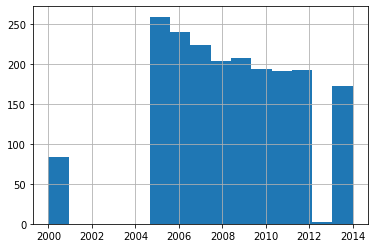

In [83]:
wrongCusipObs['year'].astype(int).hist(bins=15)